# Time-series classification of binary heartbeat using ML

Dataset: https://www.timeseriesclassification.com/description.php?Dataset=BinaryHeartbeat

We adopt the ML methods to classifiy the time series of heartbeat.

We have two classes: normal and abnormal. We extract the features using the package, tsfel.
<br>
We then perform the oversampling for the imbalanced dataset. We demonstrate the three different
ML appraoches for binary classification:
<li> RandomForest Classifier
<li> XGBoost Classifier
<li> LightGBM Classifier
<br>
<br>
We compare the performance among them.

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
from time import time
import tsfel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# The data can be downloaded from https://www.timeseriesclassification.com/description.php?Dataset=BinaryHeartbeat
train = arff.loadarff('BinaryHeartbeat_TRAIN.arff')
test = arff.loadarff('BinaryHeartbeat_TEST.arff')

In [3]:
train = pd.DataFrame(train[0])
test = pd.DataFrame(test[0])

We have two classes: normal and abnormal.

We plot the two time-series from the normal and abnormal classes.

<AxesSubplot:>

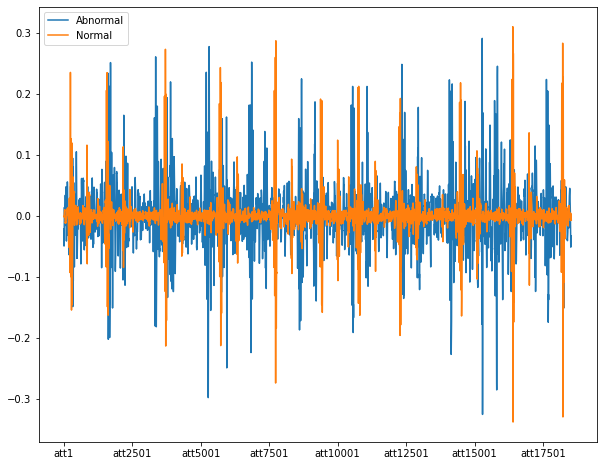

In [4]:
temp = pd.concat([train[train.target==b'Abnormal'].iloc[0,:-1], train[train.target==b'Normal'].iloc[0,:-1]], axis=1)
temp.columns = ['Abnormal', 'Normal']
temp.plot(figsize=(10,8))

# Feature extraction using tsfel

In [5]:
# Parameters
fs = 100

window = None

verbose = 0

In [6]:
cfg_file = tsfel.get_features_by_domain() 

In [7]:
train[train.target==b'Abnormal'].iloc[0,:-1]
abnormal = tsfel.time_series_features_extractor(cfg_file, train[train.target==b'Abnormal'].iloc[0,:-1], fs=fs, window_size=window, verbose=verbose)
train[train.target==b'Normal'].iloc[0,:-1]
normal = tsfel.time_series_features_extractor(cfg_file, train[train.target==b'Normal'].iloc[0,:-1], fs=fs, window_size=window, verbose=verbose)

It generates 390 features without inputing window size.

In [8]:
temp = pd.concat([abnormal.T,normal.T],axis=1)
temp.columns = ['Abnormal', 'Normal']
temp.head()

,Abnormal,Normal
0_FFT mean coefficient_0,0.000025,0.000003
0_FFT mean coefficient_1,0.000042,0.000008
0_FFT mean coefficient_2,0.000145,0.000042
0_FFT mean coefficient_3,0.000791,0.000126
0_FFT mean coefficient_4,0.001476,0.000222


In [9]:
temp.tail()

,Abnormal,Normal
0_Signal distance,1.852964e+04,1.852962e+04
0_Slope,-2.845797e-09,2.833161e-09
0_Sum absolute diff,9.050949e+01,5.692603e+01
0_Total energy,2.859876e-01,1.050988e-01
0_Zero crossing rate,6.970000e+02,1.105000e+03


In [16]:
def ts_featureextract(data, cfg_file, fs, window, verbose):
    size = len(data.columns)
    temp = pd.DataFrame()
    for i in range(size):
        extract = tsfel.time_series_features_extractor(cfg_file, data.iloc[:,i], 
                                                       fs=fs, window_size=window, 
                                                       verbose=verbose)
        extract = pd.DataFrame(extract.values.reshape(1,-1))
        temp = pd.concat([temp, extract], axis=0)

    return temp.values

In [17]:
temp = train.iloc[:,:-1].T.reset_index(drop=True)
train_X = ts_featureextract(temp, cfg_file, fs, window, verbose)

In [20]:
temp = test.iloc[:,:-1].T.reset_index(drop=True)
test_X = ts_featureextract(temp, cfg_file, fs, window, verbose)

We label the classes, abnormal and normal as an integer 0 and 1, respectively.

In [21]:
le = LabelEncoder()
train_y =le.fit_transform(train.iloc[:,-1])
test_y =le.fit_transform(test.iloc[:,-1])

In [22]:
values, counts = np.unique(train_y, return_counts=True)
print("Labels count", dict(zip(values, counts)))

Labels count {0: 149, 1: 55}


The sample is imbalanced.

# Oversampling using SMOTE

We adopt the oversampling by using the package, SMOTE.

In [23]:
smote = SMOTE(k_neighbors=6)

In [24]:
resampled_X, resampled_y = smote.fit_resample(train_X,train_y)

In [25]:
values, counts = np.unique(resampled_y, return_counts=True)
print("Labels count", dict(zip(values, counts)))

Labels count {0: 149, 1: 149}


The sample after oversampling becomes balanced.

# Random Forest Classifier

In [26]:
#Parameters:
num_iteration = 300

In [27]:
steps = [('scale',StandardScaler()), ('clf',RandomForestClassifier(random_state=21))]
pipeline = Pipeline(steps)

In [28]:
param_dist={'clf__n_estimators':np.arange(2,100,1),
            'clf__max_depth':np.arange(2,100,1), 
            'clf__max_features':np.arange(1,10,1),
            'clf__min_samples_split':[2,3,4,5]}

In [29]:
clf_cv=RandomizedSearchCV(pipeline, param_dist, n_iter=num_iteration)

In [30]:
start = time()
clf_cv.fit(resampled_X,resampled_y)
end = time()
print("Training time: ",end - start)

Training time:  123.26213526725769


In [31]:
def classification_metrics(truedata, pred):
    print("Metrics")
    print("=======================")
    tn, fp, fn, tp = confusion_matrix(truedata, pred).ravel()
    print("True positive: ", tp)
    print("True negative: ", tn)
    print("False positive: ", fp)
    print("False negative: ", fn)
    print()
    print("Accuracy: ", round(accuracy_score(truedata, pred),3))
    print("F1 score: ", round(f1_score(truedata, pred),3))
    print("Precision: ", round(precision_score(truedata, pred),3))
    print("Recall: ", round(recall_score(truedata, pred),3))

Performance

In [32]:
classification_metrics(test_y, clf_cv.predict(test_X))

Metrics
True positive:  30
True negative:  106
False positive:  44
False negative:  25

Accuracy:  0.663
F1 score:  0.465
Precision:  0.405
Recall:  0.545


In [33]:
fpr = {} 
tpr = {}
roc_auc = {}
fpr["RandomForest"], tpr["RandomForest"], thresholds = roc_curve(test_y, clf_cv.predict_proba(test_X)[:,1])
roc_auc["RandomForest"] = round(auc(fpr["RandomForest"], tpr["RandomForest"]),2)

# XGBoost Classifier

In [34]:
steps=[('scale',StandardScaler()), ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                                                            verbosity = 0, 
                                                            random_state=21, 
                                                            nthread=4))]
pipeline=Pipeline(steps)

In [35]:
param_dist={'clf__n_estimators':np.arange(2,100,1),
            'clf__max_depth':np.arange(2,100,1),
            'clf__eta':np.arange(0.01,.2,.02),
            'clf__lambda':np.arange(0.1,10,0.1), 
            'clf__alpha':np.arange(0.1,10,0.1)}

In [36]:
clf_cv=RandomizedSearchCV(pipeline, param_dist, n_iter=num_iteration)

In [37]:
start = time()
clf_cv.fit(resampled_X,resampled_y)
end = time()
print("Training time: ", end - start)

Training time:  470.9654104709625


Performance

In [38]:
classification_metrics(test_y, clf_cv.predict(test_X))

Metrics
True positive:  25
True negative:  113
False positive:  37
False negative:  30

Accuracy:  0.673
F1 score:  0.427
Precision:  0.403
Recall:  0.455


In [39]:
fpr["XGBoost"], tpr["XGBoost"], thresholds = roc_curve(test_y, clf_cv.predict_proba(test_X)[:,1])
roc_auc["XGBoost"] = round(auc(fpr["XGBoost"], tpr["XGBoost"]),2)

# LightGBM Classifier

In [40]:
steps=[('scale',StandardScaler()), ('clf',lgb.LGBMClassifier(n_jobs=2, random_state=21))]
pipeline=Pipeline(steps)

In [41]:
param_dist={'clf__n_estimators':np.arange(2,50,1),'clf__max_depth':np.arange(2,50,1),
            'clf__learning_rate':np.arange(.1,1,.05), 'clf__num_leaves':[5,10,20,30,35],
           'clf__reg_alpha':np.arange(0.1,10,0.1), 'clf__reg_lambda':np.arange(0.1,10,0.1)}

In [42]:
clf_cv=RandomizedSearchCV(pipeline, param_dist, n_iter=num_iteration)

In [43]:
start = time()
clf_cv.fit(resampled_X,resampled_y)
end = time()
print("Training time: ", end - start)

Training time:  68.1273980140686


Performance

In [44]:
classification_metrics(test_y, clf_cv.predict(test_X))

Metrics
True positive:  29
True negative:  119
False positive:  31
False negative:  26

Accuracy:  0.722
F1 score:  0.504
Precision:  0.483
Recall:  0.527


In [45]:
fpr["LightGBM"], tpr["LightGBM"], thresholds = roc_curve(test_y, clf_cv.predict_proba(test_X)[:,1])
roc_auc["LightGBM"] = round(auc(fpr["LightGBM"], tpr["LightGBM"]),2)

# Plot of ROC

In [46]:
column = ["RandomForest", "XGBoost", "LightGBM"]

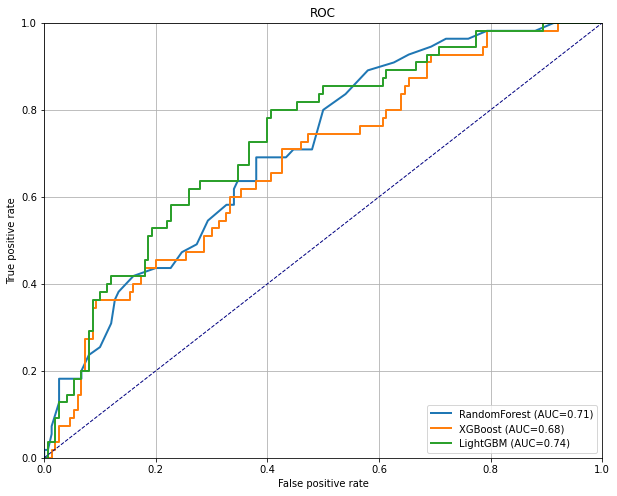

In [48]:
plt.figure(figsize=(10,8))
for col in column:
    plt.plot(fpr[col], tpr[col], lw=2, label="{} (AUC={})".format(col,roc_auc[col]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("ROC")
plt.grid(True)
ax = plt.gca()
plt.legend(loc='lower right')